[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/biodatlab/deep-learning-skooldio/blob/master/04_pytorch_for_tabular_data.ipynb)


## **Predicting second hand car price from Rodkaidee: Regression**

This notebook contains the following steps for predicting second hand car price from [Rodkaidee website](https://rod.kaidee.com/)

- Import libraries
- Prepare data: Categorical and numerical features
- Train linear regression model
- Train one-layer neural network model for regression (equivalent to linear regression)
- Train multi-layer neural network model for regression

In [1]:
import os
import os.path as op

import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error
import joblib

## **Data Preparation**

- Download data from [`github.com/biodatlab/deep-learning-skooldio`](https://github.com/biodatlab/deep-learning-skooldio)
- Clean and split data

In [ ]:
!git clone https://github.com/biodatlab/deep-learning-skooldio

In [2]:
df = pd.read_csv(op.join("deep-learning-skooldio", "rodkaidee-dataset", "Rodkaidee Data.csv"))
df.head(5)

,Brand,Model,Engine,Segment,Year,Mileage,Province,Price,Color
0,Mazda,Mazda2,1.3,B-Segment,2022,"15,640",กรุงเทพมหานคร,"499,000",Gray
1,Suzuki,Celerio,1.0,Eco Car,2021,"9,545",กรุงเทพมหานคร,"315,000",White
2,Mitsubishi,Mirage,1.2,Eco Car,2021,"10,900",นนทบุรี,"335,000",Gray
3,Nissan,March,1.2,Eco Car,2021,"12,000",กรุงเทพมหานคร,"339,000",Silver
4,Mitsubishi,Attrage,1.2,Eco Car,2021,"25,706",กาญจนบุรี,"350,000",Gray


## Clean and split data 

In [5]:
import os.path as op

df["Price"] = df["Price"].apply(lambda x: float(str(x).replace(",", "")))
df["Mileage"] = df["Mileage"].apply(lambda x: float(str(x).replace(",", "")))
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)

## Apply One-hot Encoding to categorical values

For example, if a column has three unique values 'A', 'B', and 'C', rows that contain 'C' will be transformed to [0, 0, 1].

In [6]:
CAT_COLUMNS = ["Brand", "Model", "Engine", "Segment", "Province", "Color"]
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

cat_train_array = ohe.fit_transform(df_train[CAT_COLUMNS])
cat_val_array = ohe.transform(df_val[CAT_COLUMNS])

## Normalize continuous values

We will use `MinMaxScaler` to normalize continuous value.
For example, column X has values from 0 to 1000000, so we need to normalize them to 0 to 1.
Alternatively `StandardScaler` is also an option.

In [7]:
year_scaler = MinMaxScaler()
mileage_scaler = MinMaxScaler()
price_scaler = MinMaxScaler()

year_scaler.fit(df_train[["Year"]])
mileage_scaler.fit(df_train[["Mileage"]])
price_scaler.fit(df_train[["Price"]])

MinMaxScaler()

## Apply one-hot encoding and normalization to create train and teset dataset

In [8]:
X_train = np.hstack([
    ohe.transform(df_train[CAT_COLUMNS]),
    year_scaler.transform(df_train[["Year"]]),
    mileage_scaler.transform(df_train[["Mileage"]]),
])
y_train = price_scaler.transform(df_train[["Price"]])

X_val = np.hstack([
    ohe.transform(df_val[CAT_COLUMNS]),
    year_scaler.transform(df_val[["Year"]]),
    mileage_scaler.transform(df_val[["Mileage"]]),
])
y_val = price_scaler.transform(df_val[["Price"]])

In [9]:
# save one-hot encoder and scaler objects with joblib
save_dir = "trained_models"
os.makedirs(save_dir, exist_ok=True)
joblib.dump(ohe, op.join(save_dir, "one_hot_encoder.joblib"))
joblib.dump(year_scaler, op.join(save_dir, "year_scaler.joblib"))
joblib.dump(mileage_scaler, op.join(save_dir, "mileage_scaler.joblib"))
joblib.dump(price_scaler, op.join(save_dir, "price_scaler.joblib"))

['trained_models\\price_scaler.joblib']

## **Train a Linear Regression Model**

In [10]:
# Fit a linear regression model to the training data.
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [11]:
y_pred_lr = lr_model.predict(X_val)
y_pred_lr.shape

(1480, 1)

## **Evaluate and plot relationship between actual and predicted values**

In [12]:
# Calculate the mean squared error between actual value and prediction
((y_val - y_pred_lr)**2).sum() / len(y_val)

# or using mean_squared_error
mean_squared_error(y_val, y_pred_lr)

2.781465045139847e+18

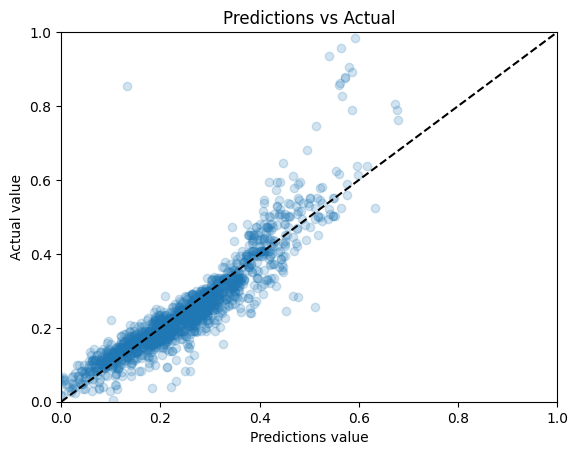

In [42]:
# Plot a perfect prediction line.
plt.plot([0, 1], [0, 1],  "--", color="black",)
# Plot the predictions vs the actual values.
plt.Figure(figsize=(10, 10))
plt.scatter(y_pred_lr, y_val, alpha=0.2)

plt.xlabel("Predictions value")
plt.ylabel("Actual value")
plt.title("Predictions vs Actual")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [43]:
joblib.dump(lr_model, "trained_models/carprice_model_linear_regression.joblib")

['trained_models/carprice_model_linear_regression.joblib']

## **Train a Neural Network to predict car price**

In [44]:
from torch.utils.data import Dataset, DataLoader

class CarPriceDataset(Dataset):
    def __init__(self, X, y = None):
        self.X = X
        if y is not None:
            self.y = y
        else:
            self.y = None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        else:
            return self.X[idx]

In [45]:
train_dataset = CarPriceDataset(X_train, y_train)
val_dataset = CarPriceDataset(X_val, y_val)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# x_sample, y_sample = next(iter(train_dataloader))
# x_sample, y_sample

In [46]:
class CarPriceModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        out = self.linear(x)
        return out

In [47]:
n_features, n_output = X_train.shape[1], y_train.shape[1]
print(n_features)
model = CarPriceModel(input_size=n_features, output_size=n_output)
model

137


CarPriceModel(
  (linear): Linear(in_features=137, out_features=1, bias=True)
)

In [48]:
def train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    loss_fn = nn.MSELoss(reduction='mean'),
    num_epochs = 100,
    update_frequency = 10,
):
    for epoch in tqdm(range(num_epochs)):
        # Set the model to training mode.
        model.train()
        for x, y in train_dataloader:
            # Forward pass.
            y_pred = model(x.float())
            # Calculate the loss.
            loss = loss_fn(y_pred, y.float())
            # Backward pass.
            loss.backward()
            # Update the model parameters.
            optimizer.step()
            # Reset the gradients.
            optimizer.zero_grad()

        # Set the model to evaluation mode and calculate the test loss at the end of each epoch.
        model.eval()
        with torch.no_grad():
            for x, y in test_dataloader:
                # Forward pass.
                y_pred = model(x.float())
                # Calculate the loss.
                loss = loss_fn(y_pred, y.float())

            # Print the loss if the epoch is a multiple of 10.
            if epoch % update_frequency == 0:
                print(f"Epoch {epoch}: {loss.item()}")


def predict(model, test_dataloader):
    model.eval()
    y_pred_list = []
    y_true_list = []
    for x, y in test_dataloader:
        y_pred = model(x.float())
        prediction = y_pred.detach().numpy()
        y = y.numpy()
        y_pred_list.extend(prediction)
        y_true_list.extend(y)
    y_pred_list = np.concatenate(y_pred_list)
    y_true_list = np.concatenate(y_true_list)
    return y_pred_list, y_true_list

In [49]:
# Define the loss function and the optimizer.
learning_rate = 1e-3
loss_fn = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model.
num_epochs = 120
update_frequency = 10

train(
    model = model,
    train_dataloader = train_dataloader,
    test_dataloader = val_dataloader,
    optimizer = optimizer,
    loss_fn = loss_fn,
    num_epochs = num_epochs,
    update_frequency = update_frequency,
)

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0: 0.018911710008978844
Epoch 10: 0.0017600910505279899
Epoch 20: 0.0013297541299834847
Epoch 30: 0.001308190869167447
Epoch 40: 0.0015048823552206159
Epoch 50: 0.00167562544811517
Epoch 60: 0.0012930043740198016
Epoch 70: 0.0011267568916082382
Epoch 80: 0.0015633931616321206
Epoch 90: 0.0011336462339386344
Epoch 100: 0.0014986732276156545
Epoch 110: 0.0008085481822490692


### Evaluate the model on the test set with Mean Squared Error

In [50]:
# Get the predictions for the test set
y_pred, y_true = predict(model, val_dataloader)

In [51]:
mean_squared_error(y_true, y_pred)

0.003201288319720353

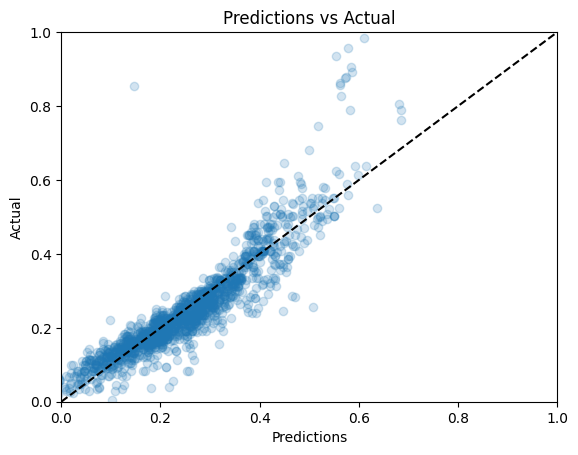

In [52]:
# Plot a perfect prediction line.
plt.plot([0, 1], [0, 1],  "--", color="black",)
# Plot the predictions vs the actual values.
plt.scatter(y_pred, y_true, alpha=0.2)

plt.xlabel("Predictions")
plt.ylabel("Actual")
plt.title("Predictions vs Actual")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [22]:
torch.save(model.state_dict(), "trained_models/carprice_model_mse_0003.pth")

## **Train a Neural Network with multiple layers (MLP)**

In [24]:
class CarPriceTwoLayerModel(nn.Module):
    def __init__(self, input_size, output_size, intermediate_dim = 10):
        super().__init__()
        self.linear1 = nn.Linear(input_size, intermediate_dim)
        self.linear2 = nn.Linear(intermediate_dim, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

model_two_layers = CarPriceTwoLayerModel(input_size=n_features, output_size=n_output)

In [25]:
# Define the loss function and the optimizer.
learning_rate = 1e-3 # = 0.001
loss_fn = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model_two_layers.parameters(), lr=learning_rate)

# Train the model.
num_epochs = 120
update_frequency = 10

train(
    model=model_two_layers,
    train_dataloader=train_dataloader,
    test_dataloader=val_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    num_epochs=num_epochs,
    update_frequency=update_frequency,
)

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0: 0.011722508817911148
Epoch 10: 0.0004526592092588544
Epoch 20: 0.0007955239270813763
Epoch 30: 0.00044417454046197236
Epoch 40: 0.0008582687587477267
Epoch 50: 0.0005005023558624089
Epoch 60: 0.000618917285464704
Epoch 70: 0.0008939540712162852
Epoch 80: 0.0008562413859181106
Epoch 90: 0.0006593684083782136
Epoch 100: 0.0005359135684557259
Epoch 110: 0.00041812745621427894


In [26]:
y_test, y_true_dl = predict(model_two_layers, val_dataloader)
mse_score = mean_squared_error(y_test, y_true_dl)
mse_score

0.0016047602396875305

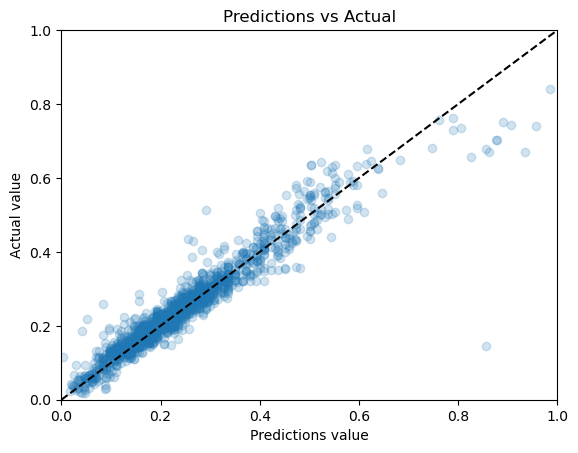

In [27]:
# Plot a perfect prediction line.
plt.plot([0, 1], [0, 1],  "--", color="black",)
# Plot the predictions vs the actual values.
plt.scatter(y_true_dl, y_test, alpha=0.2)

plt.xlabel("Predictions value")
plt.ylabel("Actual value")
plt.title("Predictions vs Actual")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [29]:
torch.save(model_two_layers.state_dict(), f"trained_models/carprice_two_layer_model_mse_00018.pth")

## **Use the models to predict on new data**

- Create a model
- Load one-hot-encoder and scaler
- Transform dataframe
- Predict

In [30]:
# load data (similar to previous code)

df = pd.read_csv("Rodkaidee Data.csv")
df["Price"] = df["Price"].apply(lambda x: float(x.replace(",", "")))
df["Mileage"] = df["Mileage"].apply(lambda x: float(x.replace(",", "")))

_, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
# create model and load trained weights
class CarPriceTwoLayerModel(nn.Module):
    def __init__(self, input_size, output_size, intermediate_dim = 10):
        super().__init__()
        self.linear1 = nn.Linear(input_size, intermediate_dim)
        self.linear2 = nn.Linear(intermediate_dim, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

model = CarPriceTwoLayerModel(137, 1)
model.load_state_dict(torch.load("trained_models/carprice_two_layer_model_mse_00018.pth"))

In [32]:
# load one-hot encoder 
one_hot_encoder_path = "trained_models/one_hot_encoder.joblib"
year_scaler_path = "trained_models/year_scaler.joblib"
mileage_scaler_path = "trained_models/mileage_scaler.joblib"
price_scaler_path = "trained_models/price_scaler.joblib"

ohe = joblib.load(one_hot_encoder_path)
year_scaler = joblib.load(year_scaler_path)
mileage_scaler = joblib.load(mileage_scaler_path)
price_scaler = joblib.load(price_scaler_path)

In [33]:
# prepare test dataset
CAT_COLUMNS = ["Brand", "Model", "Engine", "Segment", "Province", "Color"]
X_test = np.hstack([
    ohe.transform(df_val[CAT_COLUMNS]),
    year_scaler.transform(df_val[["Year"]]),
    mileage_scaler.transform(df_val[["Mileage"]]),
])
test_dataset = CarPriceDataset(X_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [34]:
def predict(model, test_dataloader):
    model.eval()
    y_pred_list = []
    for x in test_dataloader:
        y_pred = model(x.float())
        prediction = y_pred.detach().numpy()
        y_pred_list.extend(prediction)
    y_pred_list = np.concatenate(y_pred_list)
    return y_pred_list

In [35]:
y_pred = predict(model, test_dataloader)
y_pred_price = price_scaler.inverse_transform(y_pred.reshape(-1, 1))

In [36]:
df_test["Pred_Price"] = y_pred_price

In [37]:
df_test.head(10)

,Brand,Model,Engine,Segment,Year,Mileage,Province,Price,Color,Pred_Price
2473,Nissan,Teana,2.5,D-Segment,2016,74111.0,กรุงเทพมหานคร,619000.0,Black,617577.43750
6730,Toyota,Altis,1.6,C-Segment,2006,260000.0,กรุงเทพมหานคร,139000.0,Gray,109950.62500
2847,Honda,City,1.5,B-Segment,2015,95473.0,เชียงใหม่,389000.0,White,407968.31250
169,Toyota,Yaris,1.2,Eco Car,2020,20000.0,กรุงเทพมหานคร,488000.0,Gray,492501.50000
2036,Mitsubishi,Attrage,1.2,Eco Car,2016,110000.0,ปทุมธานี,259000.0,Red,269240.93750
6353,Toyota,Camry,2.0,D-Segment,2008,160000.0,กรุงเทพมหานคร,249000.0,Red,381716.81250
4500,Toyota,Vios,1.5,B-Segment,2012,187862.0,กรุงเทพมหานคร,248000.0,Gold,283114.62500
5837,Nissan,Teana,2.0,D-Segment,2010,276284.0,นครราชสีมา,329000.0,White,282092.40625
3491,Toyota,Altis,1.8,C-Segment,2014,59346.0,กรุงเทพมหานคร,460000.0,White,451001.65625
1302,Toyota,Camry,2.5,D-Segment,2018,120000.0,กรุงเทพมหานคร,888000.0,White,804756.37500


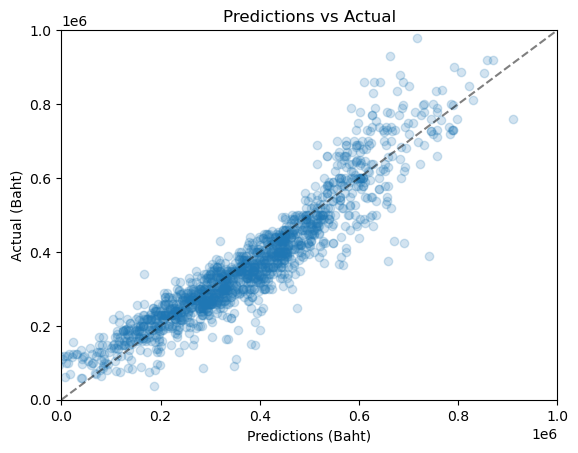

In [38]:
plt.plot([0, 1_000_000], [0, 1_000_000], color="black", alpha=0.5, linestyle="--")

plt.scatter(df_test["Pred_Price"].values, df_test["Price"], alpha=0.2)
plt.xlabel("Predictions (Baht)")
plt.ylabel("Actual (Baht)")
plt.title("Predictions vs Actual")

plt.xlim(0, 1_000_000)
plt.ylim(0, 1_000_000)
plt.show()